Jacob Hessのコードを参考に書いています。
 https://github.com/hessjacob/Quantitative-Macro-Models/blob/main/Neoclassical%20Growth/Python/Deterministic/VFI/NCGM_Det_VFI.py

実行する前に、右上のトグルからランタイムをGPUに変えてください。T4 GPUがいいかと思います。

状態変数はkのみです。value functionとpolicy functionをニューラルネットワークで置いています。value functionは両辺の差を損失関数として最小化、policy functionはvalue functionの更新後にベルマン方程式の右辺を最大化するように更新させます。
最後に定常状態を計算し、解析解と一致するか確認します。(微妙にズレます)

In [13]:
import time
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


↑がcudaになってたらGPUに接続できています。

In [15]:
class ValueNetwork(nn.Module):
    def __init__(self, hidden_size=24):
        super(ValueNetwork, self).__init__()
        self.dense1 = nn.Linear(1, hidden_size)
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        self.dense3 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.Tanh = nn.Tanh()

    def forward(self, x):
        x = self.dense1(x)
        x = self.Tanh(x)
        x = self.dense2(x)
        x = self.Tanh(x)
        x = self.dense3(x)
        x = self.Tanh(x)
        x = self.output(x)
        return x

class PolicyNetwork(nn.Module):
    def __init__(self, hidden_size=24):
        super(PolicyNetwork, self).__init__()
        self.dense1 = nn.Linear(1, hidden_size)
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        self.dense3 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.Tanh = nn.Tanh()

    def forward(self, x):
        x = self.dense1(x)
        x = self.Tanh(x)
        x = self.dense2(x)
        x = self.Tanh(x)
        x = self.dense3(x)
        x = self.Tanh(x)
        x = self.output(x)
        return x

In [16]:
def pretrain(network, optimizer, data_loader, grid_k, epochs=100, lr=0.01):
    optimizer = optim.Adam(network.parameters(), lr=lr)
    criterion = nn.MSELoss()  # 平均二乗誤差を損失関数として使用

    for epoch in range(epochs):
        total_loss = 0
        for data in data_loader:
            inputs = data.to(device)  # dataloaderからのデータがGPUに転送
            targets = inputs  # プレトレーニングではgrid_k自体をターゲットとする

            optimizer.zero_grad()  # 勾配を初期化
            outputs = network(inputs)  # ネットワークの出力を計算
            loss = criterion(outputs, targets)  # 損失を計算
            loss.backward()  # 勾配を計算
            optimizer.step()  # オプティマイザを使ってパラメータを更新

            total_loss += loss.item()

    # 最終的な出力をプロットする
    print("Final output plot after pretraining:")

    # grid_kを入力に使って出力をプロット
    inputs = torch.tensor(grid_k, dtype=torch.float64).unsqueeze(1).to(device)  # grid_kをテンソルに変換しGPUに転送
    outputs = network(inputs).detach().cpu().numpy()  # ネットワークの出力を計算

    # プロット
    plt.plot(grid_k, outputs, label='Pretrained Output')
    plt.plot(grid_k, grid_k, linestyle='--', label='Grid_k (Target)')
    plt.title('Network Output After Pretraining')
    plt.xlabel('Input (grid_k)')
    plt.ylabel('Output')
    plt.legend()
    plt.show()


In [17]:
class CapitalDataset(Dataset):
    def __init__(self, data):
        super(CapitalDataset, self).__init__()
        self.data = torch.tensor(data, dtype=torch.float64).view(-1,1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [18]:
def utility(c, sigma):
    eps = torch.tensor(1e-8, dtype=torch.float64).to(device)

    if sigma == 1:
        return torch.log(torch.max(c, eps))
    else:
        return (torch.max(c, eps)**(1-sigma) - 1) / (1 - sigma)

In [19]:
def vfi_det(params, value, policy, optimizer_value, optimizer_policy, dataloader):
    sigma, beta, delta, alpha, grid_k, tol, epoch = params
    for t in range(epoch):
        diff = 0  # To track the maximum update difference
        count = 0
        for k in dataloader:
            k = k.to(device)  # GPUにデータ転送
            count += 1
            max_c = k.squeeze()**alpha + (1-delta)*k.squeeze()

            c = torch.clamp(policy(k).squeeze(1), min=torch.tensor(0, dtype=torch.float64).to(device), max=max_c)
            u = utility(c, sigma)
            u[c < 0] = -10e10
            k_next = max_c - c

            k_next = k_next.unsqueeze(1)

            # Bellman equation
            pre_value = value(k).detach()
            value_k_detached = value(k_next)

            bellman = u + beta * value_k_detached.squeeze(1)
            bellman = bellman.detach()

            # Left-hand side - value(k) should learn to match the right-hand side
            loss = (value(k).squeeze(1) - bellman).pow(2).mean()
            optimizer_value.zero_grad()
            loss.backward(retain_graph=True)
            optimizer_value.step()

            # Policy update
            bellman_policy = u + beta * value(k_next)
            loss_policy = -torch.mean(bellman_policy)
            optimizer_policy.zero_grad()
            loss_policy.backward()
            optimizer_policy.step()

            # Calculate the update difference for stopping criterion
            diff = max(diff, torch.abs(value(k) - pre_value).mean().item())
            with torch.no_grad():
                if count == 3:
                    print(f"Epoch {t+1}, Loss: {loss.item()}")

        # Break if the maximum difference is below the tolerance
        if diff < tol:
            print(f"Converged at epoch {t+1} with diff {diff}")
            break

    grid_k = torch.tensor(grid_k, dtype=torch.float64).view(-1,1).to(device)
    consumption = policy(grid_k).squeeze(1).detach().cpu().numpy()
    return consumption, t

In [20]:
class Neoclassical_NN:
    def __init__(self, plott=1, transition=1):
        self.plott = plott  # select 1 to make plots
        self.transition = transition  # select 1 to do transition
        self.value = ValueNetwork().to(device)  # モデルをGPUに転送
        self.policy = PolicyNetwork().to(device)  # モデルをGPUに転送
        self.optimizer_value = optim.Adam(self.value.parameters(), lr=0.001)
        self.optimizer_policy = optim.Adam(self.policy.parameters(), lr=0.001)

        # 学習率減衰の設定 (0.01 -> 0.00001)
        gamma = (0.00001 / 0.01) ** (1 / 1000)
        self.setup_parameters()
        self.setup_grid()

        # Dataset and dataloader creation
        self.batch_size = 128
        self.dataset = CapitalDataset(self.grid_k)
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)

        self.params = self.sigma, self.beta, self.delta, self.alpha, self.grid_k, self.tol, self.epoch

        if self.plott != 1 and self.plott != 0:
            raise Exception("Plot option incorrectly entered: Choose either 1 or 0.")

        if self.transition != 1 and self.transition != 0:
            raise Exception("Transition option incorrectly entered: Choose either 1 or 0.")

    def setup_parameters(self):
        self.sigma = 2  # CRRA coefficient
        self.beta = 0.95  # discount factor
        self.delta = 0.1  # depreciation rate
        self.alpha = 1 / 3  # Cobb-Douglas coefficient

        self.k_ss = (self.alpha / (1 / self.beta - (1 - self.delta))) ** (1 / (1 - self.alpha))
        self.c_ss = self.k_ss ** self.alpha - self.delta * self.k_ss
        self.i_ss = self.delta * self.k_ss
        self.y_ss = self.k_ss ** self.alpha

        self.tol = 1e-8
        self.maxit = 2000
        self.epoch = 1000

        self.Nk = 128*5
        self.dev = 0.9
        self.k_min = (1 - self.dev) * self.k_ss
        self.k_max = (1 + self.dev) * self.k_ss

        self.sim_T = 75
        self.perc = 0.5
        self.cheb_order = 10

    def setup_grid(self):
        self.grid_k = np.linspace(self.k_min, self.k_max, self.Nk)

    def perfect_foresight_transition(self):
        trans_k = torch.zeros(self.sim_T + 1).double().to(device)
        trans_k[0] = self.perc * self.k_ss
        trans_cons = torch.zeros(self.sim_T).double().to(device)
        for t in range(self.sim_T):
            trans_cons[t] = self.policy(trans_k[t].view(-1, 1)).squeeze(1)
            trans_k[t + 1] = trans_k[t] ** self.alpha + (1 - self.delta) * trans_k[t] - trans_cons[t]
        trans_output = trans_k[0:-1] ** self.alpha
        trans_inv = trans_k[1:] - (1 - self.delta) * trans_k[0:-1]

        return trans_k.detach().cpu().numpy(), trans_cons.detach().cpu().numpy(), trans_output.detach().cpu().numpy(), trans_inv.detach().cpu().numpy()

    def pretrain_models(self, pretrain_epochs=100):
        print("Pretraining Value Network...")
        pretrain(self.value, self.optimizer_value, self.dataloader, self.grid_k, epochs=pretrain_epochs)

        print("Pretraining Policy Network...")
        pretrain(self.policy, self.optimizer_policy, self.dataloader, self.grid_k, epochs=pretrain_epochs)

    def solve_model(self):
        t0 = time.time()

        # Pretrain models
        self.pretrain_models(pretrain_epochs=20)

        print("\nSolving social planner problem...")
        self.pol_cons, self.t = vfi_det(self.params, self.value, self.policy, self.optimizer_value, self.optimizer_policy, self.dataloader)

        if self.t < self.maxit - 1:
            print(f"Converged in {self.t} iterations.")
        else:
            print("Did not converge.")

        t1 = time.time()
        print(f"Time: {t1 - t0:.2f} seconds")

        if self.transition:
            print("\nSteady State Transition...")
            self.trans_k, self.trans_cons, self.trans_output, self.trans_inv = self.perfect_foresight_transition()

            t2 = time.time()
            print(f'Transition iteration time elapsed: {t2 - t1:.2f} seconds')

        if self.plott:
            print('\nPlotting...')
            plt.plot(self.grid_k, self.value(torch.tensor(self.grid_k, dtype=torch.float64).view(-1, 1).to(device)).detach().cpu().numpy())
            plt.title('Value Function')
            plt.xlabel('Capital Stock')
            plt.show()

            plt.plot(self.grid_k, self.policy(torch.tensor(self.grid_k, dtype=torch.float64).view(-1, 1).to(device)).detach().cpu().numpy())
            plt.title('Next Period Capital Stock Policy Function')
            plt.xlabel('Capital Stock')
            plt.plot([self.k_min, self.k_max], [self.k_min, self.k_max], linestyle=':')
            plt.legend(['Policy Function', '45 Degree Line'])
            plt.show()

            plt.plot(self.grid_k, self.pol_cons)
            plt.title('Consumption Policy Function')
            plt.xlabel('Capital Stock')
            plt.show()

            if self.transition:
                plt.plot(np.arange(self.sim_T), self.trans_k[:-1])
                plt.plot(np.arange(self.sim_T), self.k_ss * np.ones(self.sim_T), linestyle='--')
                plt.title('Transition Dynamics: Capital Stock')
                plt.xlabel('Time')
                plt.show()

                plt.plot(np.arange(self.sim_T), self.trans_cons)
                plt.plot(np.arange(self.sim_T), self.c_ss * np.ones(self.sim_T), linestyle='--')
                plt.title('Transition Dynamics: Consumption')
                plt.xlabel('Time')
                plt.show()

                plt.plot(np.arange(self.sim_T), self.trans_output)
                plt.plot(np.arange(self.sim_T), self.y_ss * np.ones(self.sim_T), linestyle='--')
                plt.title('Transition Dynamics: Output')
                plt.xlabel('Time')
                plt.show()

                plt.plot(np.arange(self.sim_T), self.trans_inv)
                plt.plot(np.arange(self.sim_T), self.i_ss * np.ones(self.sim_T), linestyle='--')
                plt.title('Transition Dynamics: Investment')
                plt.xlabel('Time')
                plt.ylim([0.3, 0.4])
                plt.show()

            t3 = time.time()
            print(f'Plot time elapsed: {t3 - t2:.2f} seconds')

        t4 = time.time()
        print(f'\nTotal Run Time: {t4 - t0:.2f} seconds')


Pretraining Value Network...
Final output plot after pretraining:


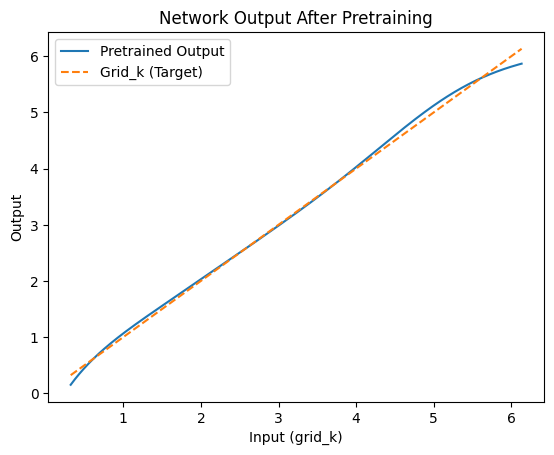

Pretraining Policy Network...
Final output plot after pretraining:


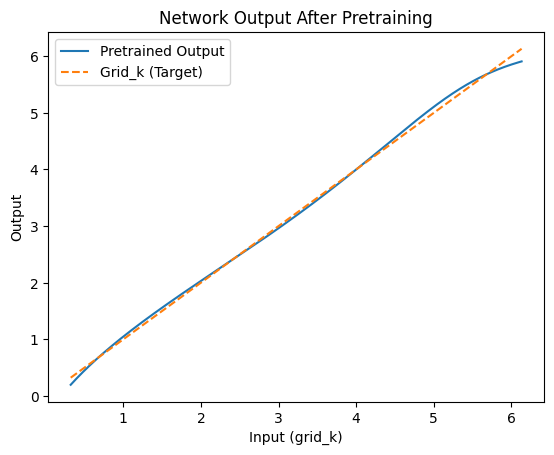


Solving social planner problem...
Epoch 1, Loss: 3.082655643810954
Epoch 2, Loss: 1.7791076955417908
Epoch 3, Loss: 0.8324554134495139
Epoch 4, Loss: 0.5420259453725239
Epoch 5, Loss: 0.18983790553295438
Epoch 6, Loss: 0.05693958000617654
Epoch 7, Loss: 0.02814570222019048
Epoch 8, Loss: 0.01963959159724602
Epoch 9, Loss: 0.019800377290703386
Epoch 10, Loss: 0.01710080358338602
Epoch 11, Loss: 0.019455142090616863
Epoch 12, Loss: 0.020338809295914577
Epoch 13, Loss: 0.02268722075627972
Epoch 14, Loss: 0.020370112759781095
Epoch 15, Loss: 0.018985258799767167
Epoch 16, Loss: 0.01599458610147583
Epoch 17, Loss: 0.014879663509501474
Epoch 18, Loss: 0.012832044851354026
Epoch 19, Loss: 0.010732409844613402
Epoch 20, Loss: 0.009153499592762546
Epoch 21, Loss: 0.006849212626847774
Epoch 22, Loss: 0.007485162527973231
Epoch 23, Loss: 0.007086273012250906
Epoch 24, Loss: 0.007273717824785349
Epoch 25, Loss: 0.005366230442980016
Epoch 26, Loss: 0.00487254005136865
Epoch 27, Loss: 0.00547998044

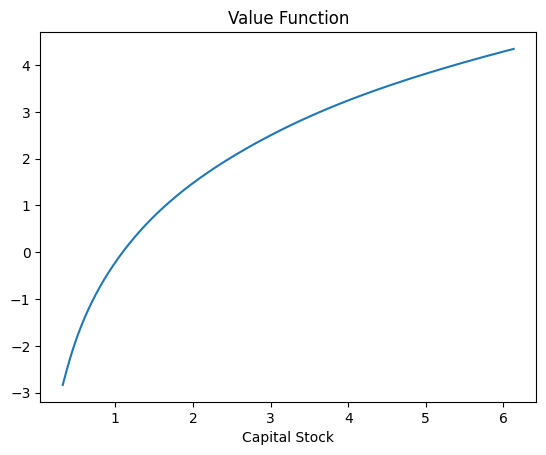

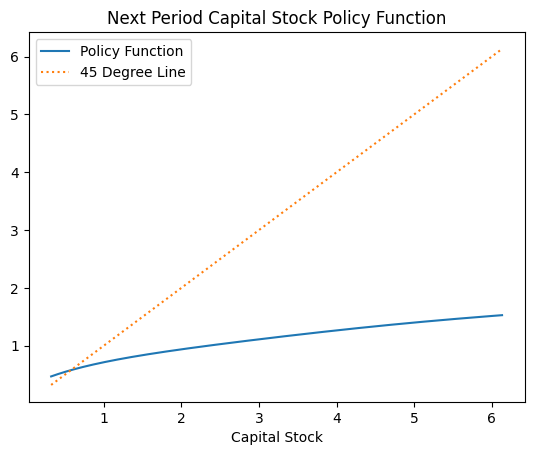

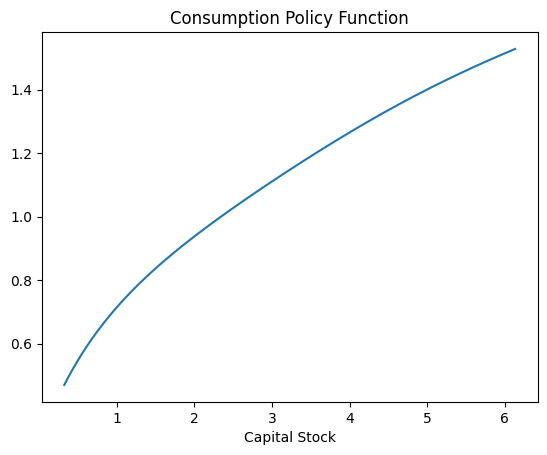

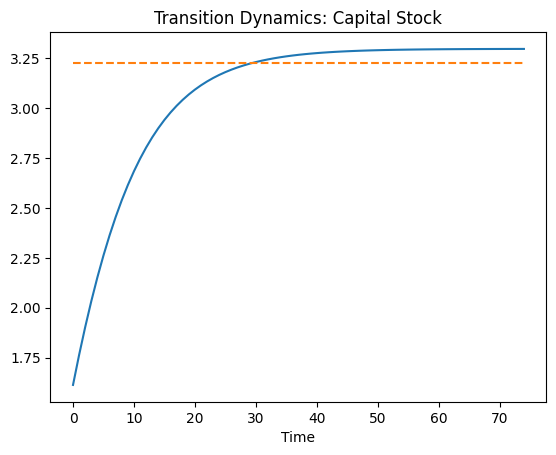

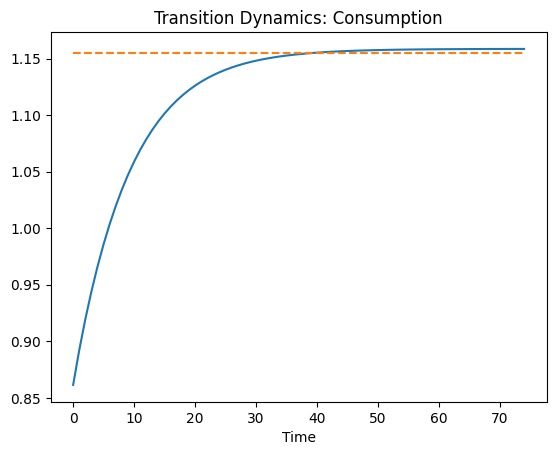

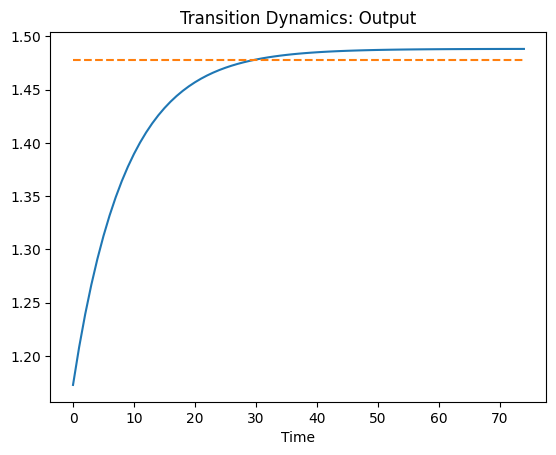

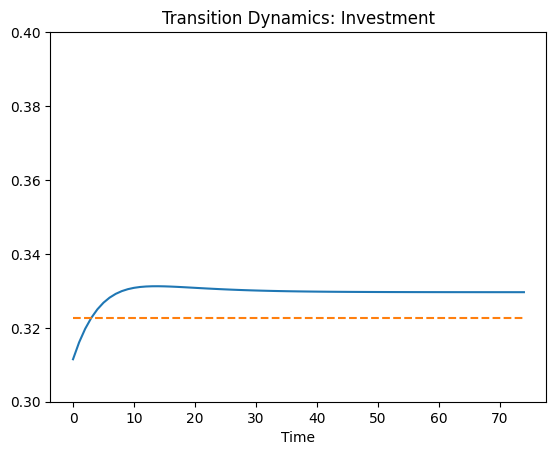

Plot time elapsed: 2.04 seconds

Total Run Time: 40.22 seconds


In [21]:
ncgm = Neoclassical_NN()
ncgm.value.double()
ncgm.policy.double()
ncgm.solve_model()